# Our Comprehensive Backtesting Framework and Strategy Rationale

In this research, we aim to rigorously test multiple investment hypotheses by constructing, cleaning, and backtesting a variety of equity trading strategies. This code base enables us to gather historical data, organize recommendations from content creators, and evaluate how different holding periods and strategic rules influence overall performance. Below is a cohesive overview of the thought process and rationale behind each major component.

---

## 1. Data Preparation and Integrity

**Objective**:  
To ensure our backtesting environment reflects real-world conditions, we begin by importing raw data and refining it:
1. **Missing Data Handling**: We drop rows lacking crucial fields (`action`, `conviction_score`, `ticker_name`) and apply corrections to common ticker errors (e.g., `APPL` → `AAPL`).
2. **Historical Data Download & Cleaning**: We leverage Polygon.io’s API to fetch daily price data, saving each ticker’s history in CSV files. Gaps in data are forward- and backward-filled (`ffill` / `bfill`) to maintain continuity, then further filtered to remove days with zero volume.
3. **Recommendation Mapping**: We associate each content creator’s recommendation (e.g., “Buy” with a certain conviction score) to the **nearest available market date**, thus aligning each action with an actual trading day.

**Why It Matters**:  
This careful data assembly safeguards our study against artifacts from missing or misaligned data. By validating that each recommendation date corresponds to a valid trading session, we establish a realistic baseline for further strategy simulation.

---

## 2. Suite of Trading Strategies

We then define multiple `bt.Strategy` subclasses in Backtrader, each capturing a distinct hypothesis about how market participants might act on recommendations.

### A. **HoldSP500Strategy** and **HoldQQQStrategy**
- **Thesis**: Test the performance of passively holding a broad market ETF (SPY) or a tech-focused ETF (QQQ).
- **Logic**: These strategies purchase shares once at the start and hold until the end of the testing window, only exiting on the final day.

### B. **BuyAndHoldStrategy**
- **Thesis**: Simulates a straightforward approach where every “Buy” recommendation is followed if no current position exists.
- **Key Detail**: Each position is sold after a user-defined holding period (e.g., 6 months, 1 year, 2 years, etc.) or at the conclusion of the backtest. This allows us to study how varying hold lengths affects returns.

### C. **BuyAndHoldWeightedStrategy**
- **Thesis**: Invest more heavily in recommendations with higher “conviction.”
- **Logic**: Collects each day’s “Buy” calls, sums their conviction scores, and allocates capital proportionally. For instance, a stock with conviction of 3 gets triple the allocation of a stock with conviction 1. This method tests the assumption that stronger calls indeed yield stronger results.

### D. **YouTuberInverseStrategy**
- **Thesis**: Investigate potential underperformance by inversely trading “Buy” signals (i.e., shorting those recommendations).
- **Logic**: Whenever the recommendation says “Buy,” this strategy **sells short** if not already in a position. The short position is exited after a predefined holding period or on the final day. This explores whether systematically countering recommendations could be profitable (akin to “betting against the influencer”).

### E. **UnclearAsBuyStrategy**
- **Thesis**: Hypothesize that if recommendations are ambiguous or “unclear,” treating them as “Buy” might still generate alpha.
- **Logic**: Similar to `BuyAndHoldStrategy`, but interprets both “Buy” and “Unclear” signals as triggers to initiate a long position. This tests the merit of including borderline recommendations.

### F. **Conviction Buckets (High, Medium, Low)**
- **Thesis**: A deeper dive into conviction scoring. Rather than weighting individual trades proportionally, we segregate entire sets of trades into three strategies:
  1. **Low Conviction**: Only trades where the conviction score is 1.
  2. **Medium Conviction**: Only trades where the conviction score is 2.
  3. **High Conviction**: Only trades where the conviction score is 3.

By comparing final returns, drawdowns, and Sharpe Ratios, we investigate how varying confidence levels in recommendations may correlate with risk-adjusted returns.

---

## 3. Backtrader and Performance Analytics

**Why Backtrader?**  
Backtrader offers a robust, event-driven simulation environment for:
- **Realistic Execution**: Each “Buy” or “Sell” occurs based on actual daily close data, with capital allocated accordingly.  
- **Risk & Return Metrics**: We employ:
  - **Sharpe Ratio** (excess return vs. volatility),
  - **Max Drawdown** (peak-to-trough loss),
  - **Annualized Return** (time-based scaling of total return),
  - **Win Rate** (percentage of profitable trades).

Together, these metrics create a multidimensional view of each strategy’s performance.

---

## 4. Holding Period Experiments

**Hypothesis**: The optimal holding period for a Buy & Hold approach may vary.  
We test multiple durations—ranging from 1 day up to 730 days—by invoking the `BuyAndHoldStrategy` with different `hold_period` parameters. Plotting final returns reveals short-term vs. long-term trade-offs and identifies which horizon historically yielded the best outcome in this dataset.

---

## 5. Quantile Analysis of Stock Performance

**Rationale**:  
By **grouping all tickers** into quintiles based on their final returns, we can see whether certain segments consistently outperform or underperform a known benchmark (QQQ). Filling the space between QQQ’s returns and the top/bottom 20% helps visualize how risk and reward concentrate among different performance strata.

**Outcome**:  
This detailed segmentation provides an additional angle, illustrating whether “best-performing” or “worst-performing” stocks deviate significantly from major indices, and whether that aligns or conflicts with the YouTuber-based recommendations.

---

## 6. Summary of Expected Findings

This multi-pronged analysis, which crosses holding periods, strategy logic, and recommendation convictions, aims to shed light on:

1. **Passive vs. Active**: Do straightforward, passive index holds (SPY, QQQ) outperform more active, conviction-weighted approaches?
2. **Impact of Conviction**: Do highly confident “Buys” truly deliver superior risk-adjusted returns, or are low/medium convictions equally profitable (or safer)?
3. **Value of Unclear Signals**: Is ignoring ambiguous calls a missed opportunity, or does it mitigate unnecessary risk?
4. **Quantile Clusters**: Are top performers rarities (i.e., in the top 20%) that significantly outpace benchmarks, or is outperformance distributed more evenly?

By pulling all these threads together—data cleaning, strategic modeling, quantile breakdowns, and backtest analytics—we seek a holistic understanding of how recommendation-based equity strategies might fare in practice.


In [190]:
import os
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from datetime import datetime
from collections import defaultdict, Counter
import backtrader as bt

In [191]:
os.environ["POLYGON_API_KEY"] = ""

In [192]:
np.random.seed(42)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

# ALL RECOMMENDATIONS
#df_stock = pd.read_csv('../prompting/data_needed_for_inference/complete_dataset.csv')

# NON PENNY RECOMMENDATIONS ONLY
df_stock = pd.read_csv('../data_analysis/notebooks/non_penny_recommendations_only.csv')

tickers = df_stock['ticker_name'].dropna().unique().tolist() + ['QQQ', 'SPY']

rows_before = df_stock.shape[0]
df_stock.dropna(subset=['action', 'conviction_score', 'ticker_name'], inplace=True)
rows_after = df_stock.shape[0]
rows_dropped = rows_before - rows_after
print(f"Number of rows: {rows_after}")
print(f"Rows dropped: {rows_dropped}")

Number of rows: 567
Rows dropped: 0


In [193]:
ticker_corrections = {
    'APPL': 'AAPL', 
    'GOOGL': 'GOOG', 
    'FB': 'META',
    'GLDLF': 'GLDG',
    'HLIX': 'HLX',
    'AI†': 'AI',
    'SKWS': 'SWKS'
}

def correct_ticker(ticker):
    return ticker_corrections.get(ticker, ticker)

def clean_ticker(ticker):
    if pd.isnull(ticker):
        return None
    ticker = ticker.strip().upper()
    ticker = ticker.split(':')[-1].split(' ')[-1].strip()
    return ticker

def process_ticker(ticker):
    ticker = clean_ticker(ticker)
    return correct_ticker(ticker) if ticker else None


historical_save_path = './historical_data'

os.makedirs(historical_save_path, exist_ok=True)

if not os.path.exists("computed_data"):
    os.makedirs("computed_data")

if not os.path.exists("computed_graphics"):
    os.makedirs("computed_graphics")

end_date = datetime(2024, 8, 1).date()
start_date = datetime(2018, 1, 1).date()

api_key = os.getenv('POLYGON_API_KEY')
if not api_key:
    raise ValueError("POLYGON_API_KEY environment variable is not set.")

processed_tickers = set()
for ticker in tickers:
    processed_ticker = process_ticker(ticker)
    if processed_ticker:
        processed_tickers.add(processed_ticker)

alternative_tickers = ['AI', 'ERNT', 'GLDG', 'GUYFF', 'HLX', 'PLTO', 'PVDA', 'SWKS', 'ZC']
failed_tickers = []

def fetch_and_save_ticker_data(ticker, api_key, start_date, end_date, save_path):
    file_path = os.path.join(save_path, f"{ticker}.csv")
    if os.path.exists(file_path):
        return True
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}"
    params = {'apiKey': api_key, 'adjusted': 'true', 'sort': 'asc', 'limit': 150000}
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Failed to fetch data for ticker {ticker}. HTTP Status Code: {response.status_code}")
        return False
    data = response.json()
    if 'results' in data and data['results']:
        df = pd.DataFrame(data['results'])
        df['datetime'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('datetime', inplace=True)
        df = df[['o', 'h', 'l', 'c', 'v']]
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        df.to_csv(file_path)
        return True
    else:
        # print(f"No results found for ticker {ticker}")
        return False

for ticker in processed_tickers:
    success = fetch_and_save_ticker_data(ticker, api_key, start_date.isoformat(), end_date.isoformat(), historical_save_path)
    if not success:
        failed_tickers.append(ticker)

historical_data = {}
date_sets = []

for ticker in processed_tickers:
    file = os.path.join(historical_save_path, f"{ticker}.csv")
    if os.path.exists(file):
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        historical_data[ticker] = df
        date_sets.append(df.index)

all_polygon_dates = pd.DatetimeIndex(sorted(set().union(*date_sets))).normalize()
for ticker, df in historical_data.items():
    df.index = pd.to_datetime(df.index).normalize()
    df = df.reindex(all_polygon_dates)
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df['Volume'] = df['Volume'].fillna(0).clip(lower=0)
    df = df[df['Volume'] > 0]
    historical_data[ticker] = df

all_dates = all_polygon_dates if not all_polygon_dates.empty else pd.DatetimeIndex([])
if not all_dates.empty:
    for ticker, df in historical_data.items():
        df = df.reindex(all_dates)
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        df['Volume'] = df['Volume'].fillna(0).clip(lower=0)
        df = df[df['Volume'] > 0]
        historical_data[ticker] = df

last_date = all_dates.max().date() if not all_dates.empty else None

strategy_recs = defaultdict(list)
for idx, row in df_stock.iterrows():
    ticker = process_ticker(row['ticker_name'])
    if not ticker:
        continue

    if ticker in historical_data:
        market_data = historical_data[ticker]
    else:
        continue

    if pd.notnull(row['action_date']):
        action_date = pd.to_datetime(row['action_date']).date()
    elif pd.notnull(row['publishedAt']):
        action_date = pd.to_datetime(row['publishedAt']).date()
    else:
        continue

    market_dates = market_data.index.date
    try:
        if action_date < market_dates.min():
            snapped_date = market_dates.min()
        elif action_date > market_dates.max():
            snapped_date = market_dates.max()
        else:
            snapped_date = min(market_dates, key=lambda d: abs(d - action_date))
    except Exception as e:
        print(f"Error processing ticker {ticker} on date {action_date}: {e}")
        continue

    strategy_recs[(ticker, snapped_date)].append({
        'ticker': ticker,
        'action': row['action'],
        'conviction_score': row['conviction_score']
    })

In [194]:
action_counts = Counter()
for recommendations in strategy_recs.values():
    for rec in recommendations:
        action_counts[rec['action']] += 1
print(f"Action counts: {action_counts}")

Action counts: Counter({'Buy': 392, 'Unclear': 133, "Don't buy": 24, 'Hold': 10, 'Sell': 6, 'Short sell': 1})


In [195]:
class MyPandasData(bt.feeds.PandasData):
    params = (('nullvalue', float('nan')), ('plot', False), ('datetime', None),
              ('open', 'Open'), ('high', 'High'), ('low', 'Low'),
              ('close', 'Close'), ('volume', 'Volume'), ('openinterest', None))

In [196]:
class HoldSP500Strategy(bt.Strategy):
    params=(('hold_period',365),('allocation_per_trade',1.0),('strategy_recs',{}),('last_date',None), ('max_size', 100))

    def __init__(self):
        self.start_traded = False

    def next(self):
        # Ensure we only buy once
        if not self.start_traded:
            for data in self.datas:
                if data._name == 'SPY':
                    cash = self.broker.getcash()
                    size = int(cash / max(data.close[0], 1e-6))  # Buy maximum possible shares
                    if size > 0:
                        self.buy(data=data, size=size)
                        self.start_traded = True

        # Liquidate all positions on the last date
        for data in self.datas:
            if data._name == 'SPY':
                pos = self.getposition(data)
                if self.datetime.date(0) == self.params.last_date and pos.size > 0:
                    self.sell(data=data, size=pos.size)
                break

In [197]:
class HoldQQQStrategy(bt.Strategy):
    params=(('hold_period',365),('allocation_per_trade',1.0),('strategy_recs',{}),('last_date',None), ('max_size', 100))

    def __init__(self):
        self.start_traded = False

    def next(self):
        # Ensure we only buy once
        if not self.start_traded:
            for data in self.datas:
                if data._name == 'QQQ':
                    cash = self.broker.getcash()
                    size = int(cash / max(data.close[0], 1e-6))  # Buy maximum possible shares
                    if size > 0:
                        self.buy(data=data, size=size)
                        self.start_traded = True

        # Liquidate all positions on the last date
        for data in self.datas:
            if data._name == 'QQQ':
                pos = self.getposition(data)
                if self.datetime.date(0) == self.params.last_date and pos.size > 0:
                    self.sell(data=data, size=pos.size)
                break

In [198]:
class BuyAndHoldStrategy(bt.Strategy):
    params=(('hold_period',365),('allocation_per_trade',1.0),('strategy_recs',{}),('last_date',None), ('max_size', 100))
    def __init__(self):
        self.buy_dates={}
        self.strategy_recs=self.params.strategy_recs
    def next(self):
        current_date=self.datetime.date(0)
        buys=[]
        for data in self.datas:
            pos=self.getposition(data)
            ticker=data._name
            recommendations=self.strategy_recs.get((ticker,current_date),[])
            for rec in recommendations:
                if rec['action']=='Buy' and not pos:
                    buys.append(data)
        num_trades=len(buys)
        if num_trades>0:
            allocation=self.broker.getcash()/num_trades
            for data in buys:
                size=int(allocation/max(data.close[0],1e-6))
                size = min(self.params.max_size, size)
                if size>0:
                    self.buy(data=data,size=size)
                    self.buy_dates[data]=current_date
        for data in self.datas:
            pos=self.getposition(data)
            if pos:
                buy_date=self.buy_dates.get(data)
                if buy_date:
                    holding_period=(current_date-buy_date).days
                    if holding_period>=self.params.hold_period or current_date==self.params.last_date:
                        self.sell(data=data,size=pos.size)
                        del self.buy_dates[data]

class BuyAndHoldWeightedStrategy(bt.Strategy):
    params=(('hold_period',365),('total_allocation',1.0),('strategy_recs',{}),('last_date',None),('max_size',100))
    def __init__(self):
        self.buy_dates={}
        self.strategy_recs=self.params.strategy_recs
    def next(self):
        current_date=self.datetime.date(0)
        buys=[]
        for data in self.datas:
            pos=self.getposition(data)
            ticker=data._name
            recommendations=self.strategy_recs.get((ticker,current_date),[])
            for rec in recommendations:
                if rec['action']=='Buy' and not pos:
                    conviction=rec.get('conviction_score',1)
                    buys.append((data,conviction))
        if buys:
            total_conviction=sum(conviction for _,conviction in buys)
            available_cash=self.broker.getcash()*self.params.total_allocation
            for data,conviction in buys:
                alloc=(conviction/total_conviction)*available_cash
                size=int(alloc/max(data.close[0],1e-6))
                size=min(size,self.params.max_size)
                if size>0:
                    self.buy(data=data,size=size)
                    self.buy_dates[data]=current_date
        for data in self.datas:
            pos=self.getposition(data)
            if pos.size>0:
                buy_date=self.buy_dates.get(data)
                holding_period=(current_date-buy_date).days if buy_date else 0
                if holding_period>=self.params.hold_period or current_date==self.params.last_date:
                    self.sell(data=data,size=pos.size)
                    self.buy_dates.pop(data,None)

In [199]:
class YouTuberInverseStrategy(bt.Strategy):
    params=(('hold_period',365),('allocation_per_trade',1.0),('strategy_recs',{}),('last_date',None), ('max_size', 100))
    def __init__(self):
        self.sell_dates={}
        self.strategy_recs=self.params.strategy_recs
    def next(self):
        current_date=self.datetime.date(0)
        sells=[]
        for data in self.datas:
            pos=self.getposition(data)
            ticker=data._name
            recommendations=self.strategy_recs.get((ticker,current_date),[])
            for rec in recommendations:
                if rec['action']=='Buy' and not pos:
                    sells.append(data)
        num_trades=len(sells)
        if num_trades>0:
            allocation=self.broker.getcash()/num_trades
            for data in sells:
                size=int(allocation/max(data.close[0],1e-6))
                size = min(self.params.max_size, size)
                if size>0:
                    self.sell(data=data,size=size)
                    self.sell_dates[data]=current_date
        for data in self.datas:
            pos=self.getposition(data)
            if pos:
                sell_date=self.sell_dates.get(data)
                if sell_date:
                    holding_period=(current_date-sell_date).days
                    if holding_period>=self.params.hold_period:
                        self.buy(data=data,size=pos.size)
                        del self.sell_dates[data]
                if current_date==self.params.last_date and pos.size>0:
                    self.buy(data=data,size=pos.size)

In [200]:
class UnclearAsBuyStrategy(bt.Strategy):
    params=(('hold_period',365),('allocation_per_trade',1.0),('strategy_recs',{}),('last_date',None), ('max_size', 100))
    def __init__(self):
        self.buy_dates={}
        self.strategy_recs=self.params.strategy_recs
    def next(self):
        current_date=self.datetime.date(0)
        buys=[]
        for data in self.datas:
            pos=self.getposition(data)
            ticker=data._name
            recommendations=self.strategy_recs.get((ticker,current_date),[])
            for rec in recommendations:
                if rec['action'] in ['Buy','Unclear'] and not pos:
                    buys.append(data)
        num_trades=len(buys)
        if num_trades>0:
            allocation=self.broker.getcash()/num_trades
            for data in buys:
                size=int(allocation/max(data.close[0],1e-6))
                size = min(self.params.max_size, size)
                if size>0:
                    self.buy(data=data,size=size)
                    self.buy_dates[data]=current_date
        for data in self.datas:
            pos=self.getposition(data)
            if pos:
                buy_date=self.buy_dates.get(data)
                if buy_date:
                    holding_period=(current_date-buy_date).days
                    if holding_period>=self.params.hold_period or current_date==self.params.last_date:
                        self.sell(data=data,size=pos.size)
                        del self.buy_dates[data]

<>:89: SyntaxWarning: invalid escape sequence '\$'
<>:89: SyntaxWarning: invalid escape sequence '\$'
<>:90: SyntaxWarning: invalid escape sequence '\$'
<>:90: SyntaxWarning: invalid escape sequence '\$'
<>:89: SyntaxWarning: invalid escape sequence '\$'
<>:89: SyntaxWarning: invalid escape sequence '\$'
<>:90: SyntaxWarning: invalid escape sequence '\$'
<>:90: SyntaxWarning: invalid escape sequence '\$'
/var/folders/qz/8l46blhj3lsg6h3hgljjlmsr0000gn/T/ipykernel_26278/411316692.py:89: SyntaxWarning: invalid escape sequence '\$'
  plt.plot(x_positions[:len(short_term)],short_term['Final_Return'],marker='o',label=f'Short Term (<=28 days) Upper: \${short_term_upper:.2f}, Lower: \${short_term_lower:.2f}',linestyle='-',color='blue')
/var/folders/qz/8l46blhj3lsg6h3hgljjlmsr0000gn/T/ipykernel_26278/411316692.py:89: SyntaxWarning: invalid escape sequence '\$'
  plt.plot(x_positions[:len(short_term)],short_term['Final_Return'],marker='o',label=f'Short Term (<=28 days) Upper: \${short_term_upper

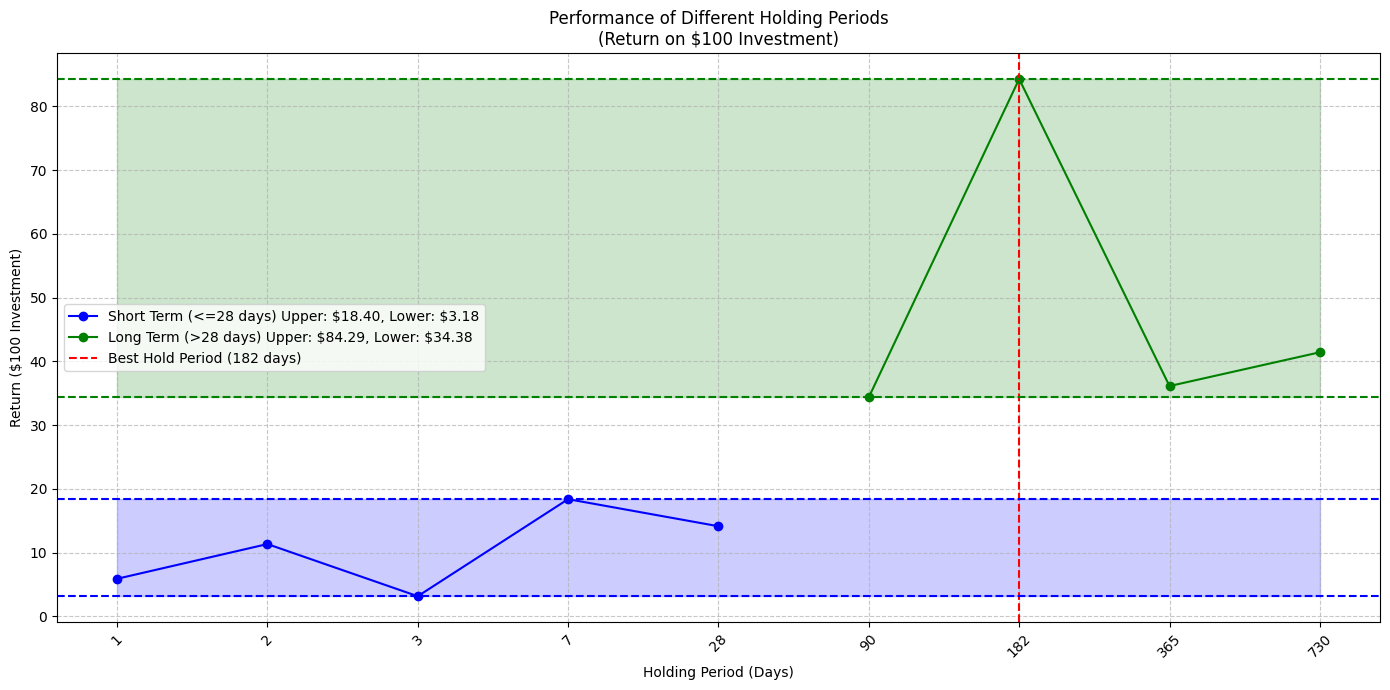

,Hold_Period,Final_Return
0,1,5.91
1,2,11.36
2,3,3.18
3,7,18.40
4,28,14.15
5,90,34.38
6,182,84.29
7,365,36.14
8,730,41.44


In [201]:
def run_backtest(strategy, name, historical_data, start_date, end_date, **strategy_params):
    cerebro = bt.Cerebro()
    strategy_params['last_date'] = last_date
    strategy_params['max_size'] = 100
    cerebro.addstrategy(strategy, **strategy_params)
    for ticker, df in historical_data.items():
        data = MyPandasData(dataname=df, name=ticker, fromdate=start_date, todate=end_date)
        cerebro.adddata(data)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.broker.setcash(100000.0)
    cerebro.broker.set_coc(True)
    results = cerebro.run()
    strat = results[0]
    sharpe_ratio = strat.analyzers.sharpe.get_analysis().get('sharperatio', None)
    drawdown = strat.analyzers.drawdown.get_analysis()
    max_drawdown = drawdown.max.drawdown
    portfolio_value = cerebro.broker.getvalue()
    initial_cash = 100000.0
    pnl = portfolio_value - initial_cash
    total_return = (portfolio_value - initial_cash) / initial_cash * 100
    returns = pd.Series(strat.analyzers.pyfolio.get_analysis()['returns'])
    returns.index = returns.index.tz_localize(None)
    cumulative_returns = (1 + returns).cumprod()
    trade_analysis = strat.analyzers.trades.get_analysis()
    total_trades = trade_analysis.total.get('closed', 0)
    winning_trades = trade_analysis.get('won', {}).get('total', 0)
    losing_trades = trade_analysis.get('lost', {}).get('total', 0)
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    all_dates = historical_data[next(iter(historical_data))].index
    start_date_ec = all_dates.min()
    end_date_ec = all_dates.max()
    total_days = (end_date_ec - start_date_ec).days
    total_years = total_days / 365.25
    annualized_return = ((portfolio_value / initial_cash) ** (1 / total_years) - 1) * 100
    analysis = {
        'name': name,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'pnl': pnl,
        'total_return': total_return,
        'annualized_return': annualized_return,
        'total_trades': total_trades,
        'winning_trades': winning_trades,
        'losing_trades': losing_trades,
        'win_rate': win_rate,
        'returns': returns,
        'cumulative_returns': cumulative_returns,
        'drawdown': drawdown,
    }
    return analysis

hold_periods=[1,2,3,7,28,90,182,365,730]
results_file="computed_data/Performance_of_Different_Holding_Periods.csv"

if not os.path.exists(results_file):
    results=[]
    for hp in hold_periods:
        analysis=run_backtest(
            BuyAndHoldStrategy,
            f'HoldPeriod_{hp}',
            historical_data,
            start_date,
            end_date,
            strategy_recs=strategy_recs,
            hold_period=hp
        )
        total_return=analysis['total_return']
        results.append([hp,total_return])
    if results:
        results_df=pd.DataFrame(results,columns=['Hold_Period','Final_Return']).sort_values('Hold_Period')
        results_df.to_csv(results_file,index=False)
else:
    results_df=pd.read_csv(results_file)

if not results_df.empty:
    best_result=results_df.loc[results_df['Final_Return'].idxmax()]
    x_positions=range(len(hold_periods))
    plt.figure(figsize=(14,7))
    short_term=results_df[results_df['Hold_Period']<=28]
    long_term=results_df[results_df['Hold_Period']>28]
    short_term_upper=short_term['Final_Return'].max()
    short_term_lower=short_term['Final_Return'].min()
    long_term_upper=long_term['Final_Return'].max()
    long_term_lower=long_term['Final_Return'].min()
    plt.plot(x_positions[:len(short_term)],short_term['Final_Return'],marker='o',label=f'Short Term (<=28 days) Upper: \${short_term_upper:.2f}, Lower: \${short_term_lower:.2f}',linestyle='-',color='blue')
    plt.plot(x_positions[len(short_term):],long_term['Final_Return'],marker='o',label=f'Long Term (>28 days) Upper: \${long_term_upper:.2f}, Lower: \${long_term_lower:.2f}',linestyle='-',color='green')
    plt.axvline(x_positions[hold_periods.index(best_result['Hold_Period'])],color='red',linestyle='--',label=f'Best Hold Period ({int(best_result["Hold_Period"])} days)')
    plt.fill_between(range(len(hold_periods)),short_term_upper,short_term_lower,color='blue',alpha=0.2)
    plt.fill_between(range(len(hold_periods)),long_term_upper,long_term_lower,color='green',alpha=0.2)
    plt.axhline(short_term_upper,color='blue',linestyle='--')
    plt.axhline(short_term_lower,color='blue',linestyle='--')
    plt.axhline(long_term_upper,color='green',linestyle='--')
    plt.axhline(long_term_lower,color='green',linestyle='--')
    plt.xticks(x_positions,labels=hold_periods,rotation=45)
    plt.title('Performance of Different Holding Periods\n(Return on $100 Investment)')
    plt.xlabel('Holding Period (Days)')
    plt.ylabel('Return ($100 Investment)')
    plt.legend()
    plt.grid(True,linestyle='--',alpha=0.7)
    plt.tight_layout()
    plt.savefig('computed_graphics/Performance_of_Different_Holding_Periods.png', dpi=300)
    plt.show()

results_df

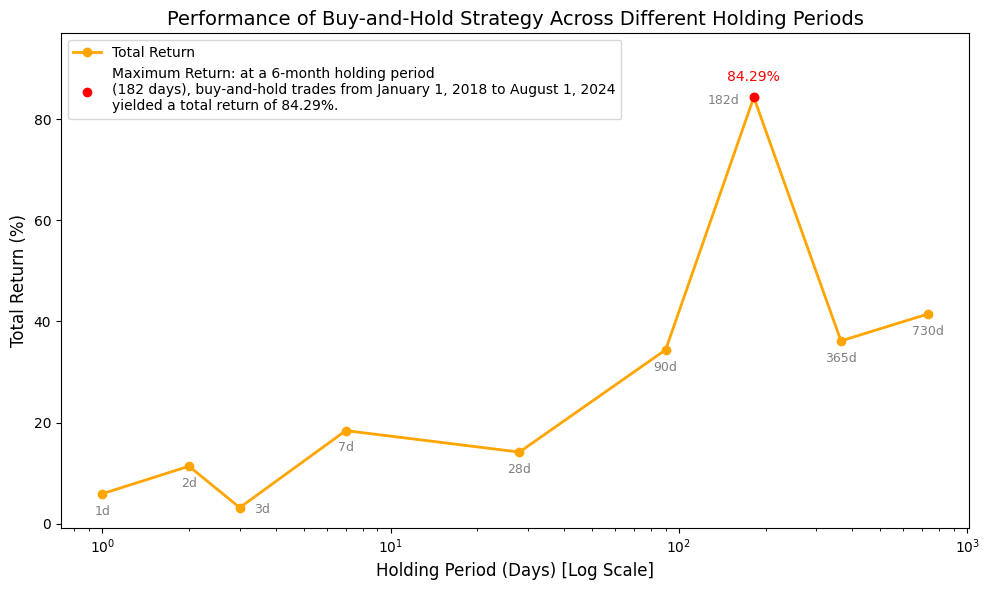

In [202]:
import matplotlib.pyplot as plt

# Assuming results_df has columns: 'Hold_Period' and 'Final_Return'
peak_idx = results_df["Final_Return"].idxmax()
peak_x = results_df["Hold_Period"][peak_idx]
peak_y = results_df["Final_Return"][peak_idx]

# Set y-limit buffer to prevent annotation cutoff
y_max_buffer = results_df["Final_Return"].max() * 1.15

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_df["Hold_Period"], results_df["Final_Return"], marker='o', linewidth=2, label="Total Return", color='orange')
plt.xscale('log')
plt.ylim(top=y_max_buffer)

# Annotate each point with its hold period (number of days)
for i in range(len(results_df)):
    x = results_df["Hold_Period"][i]
    y = results_df["Final_Return"][i]
    
    if x == 182:
        # Shift 182d to the left of the point
        plt.annotate(f'{x}d', (x, y), textcoords="offset points", xytext=(-10, -5), ha='right', fontsize=9, color='gray')
    elif x == 3:
        # Shift 3d to the right of the point
        plt.annotate(f'{x}d', (x, y), textcoords="offset points", xytext=(10, -4), ha='left', fontsize=9, color='gray')
    else:
        # Default placement for other points
        plt.annotate(f'{x}d', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=9, color='gray')

# Highlight peak point separately
plt.scatter(peak_x, peak_y, color='red', zorder=5, 
            label=f'Maximum Return: at a 6‑month holding period\n({peak_x} days), buy‑and‑hold trades from January 1, 2018 to August 1, 2024\nyielded a total return of {peak_y:.2f}%.')
plt.annotate(f'{peak_y:.2f}%', (peak_x, peak_y), textcoords="offset points", xytext=(0, 12), ha='center', fontsize=10, color='red')

# Labels and title
plt.title("Performance of Buy-and-Hold Strategy Across Different Holding Periods", fontsize=14)
plt.xlabel("Holding Period (Days) [Log Scale]", fontsize=12)
plt.ylabel("Total Return (%)", fontsize=12)

# Move legend to upper left
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig("computed_graphics/optimal_holding_period.png", dpi=300, bbox_inches='tight')
plt.show()






In [203]:
unclear_as_buy = run_backtest(UnclearAsBuyStrategy, 'UnclearAsBuy', historical_data, start_date, end_date, strategy_recs=strategy_recs)

In [204]:
youtuber_inverse = run_backtest(YouTuberInverseStrategy, 'YouTuberInverse', historical_data, start_date, end_date, strategy_recs=strategy_recs)

In [205]:
buy_and_hold_weighted = run_backtest(BuyAndHoldWeightedStrategy, 'BuyAndHoldWeighted', historical_data, start_date, end_date, strategy_recs=strategy_recs)

In [206]:
hold_qqq = run_backtest(HoldQQQStrategy, 'HoldQQQ', historical_data, start_date, end_date)

In [207]:
hold_sp500 = run_backtest(HoldSP500Strategy, 'HoldSP500', historical_data, start_date, end_date)

In [208]:
buy_and_hold_6_months = run_backtest(BuyAndHoldStrategy, 'BuyAndHold_6Months', historical_data, start_date, end_date, strategy_recs=strategy_recs, hold_period=182)

In [209]:
buy_and_hold_1_year = run_backtest(BuyAndHoldStrategy, 'BuyAndHold_1Year', historical_data, start_date, end_date, strategy_recs=strategy_recs, hold_period=365)

In [210]:
buy_and_hold_2_years = run_backtest(BuyAndHoldStrategy, 'BuyAndHold_2Years', historical_data, start_date, end_date, strategy_recs=strategy_recs, hold_period=730)

In [211]:
buy_and_hold_5_years = run_backtest(BuyAndHoldStrategy, 'BuyAndHold_5Years', historical_data, start_date, end_date, strategy_recs=strategy_recs, hold_period=1825)

In [212]:
buy_and_hold_10_years = run_backtest(BuyAndHoldStrategy, 'BuyAndHold_10Years', historical_data, start_date, end_date, strategy_recs=strategy_recs, hold_period=3650)

In [213]:
analyses = [
    unclear_as_buy,
    youtuber_inverse,
    buy_and_hold_weighted,
    hold_qqq,
    hold_sp500,
    buy_and_hold_6_months,
    buy_and_hold_1_year,
    buy_and_hold_2_years,
    buy_and_hold_5_years,
    buy_and_hold_10_years
]

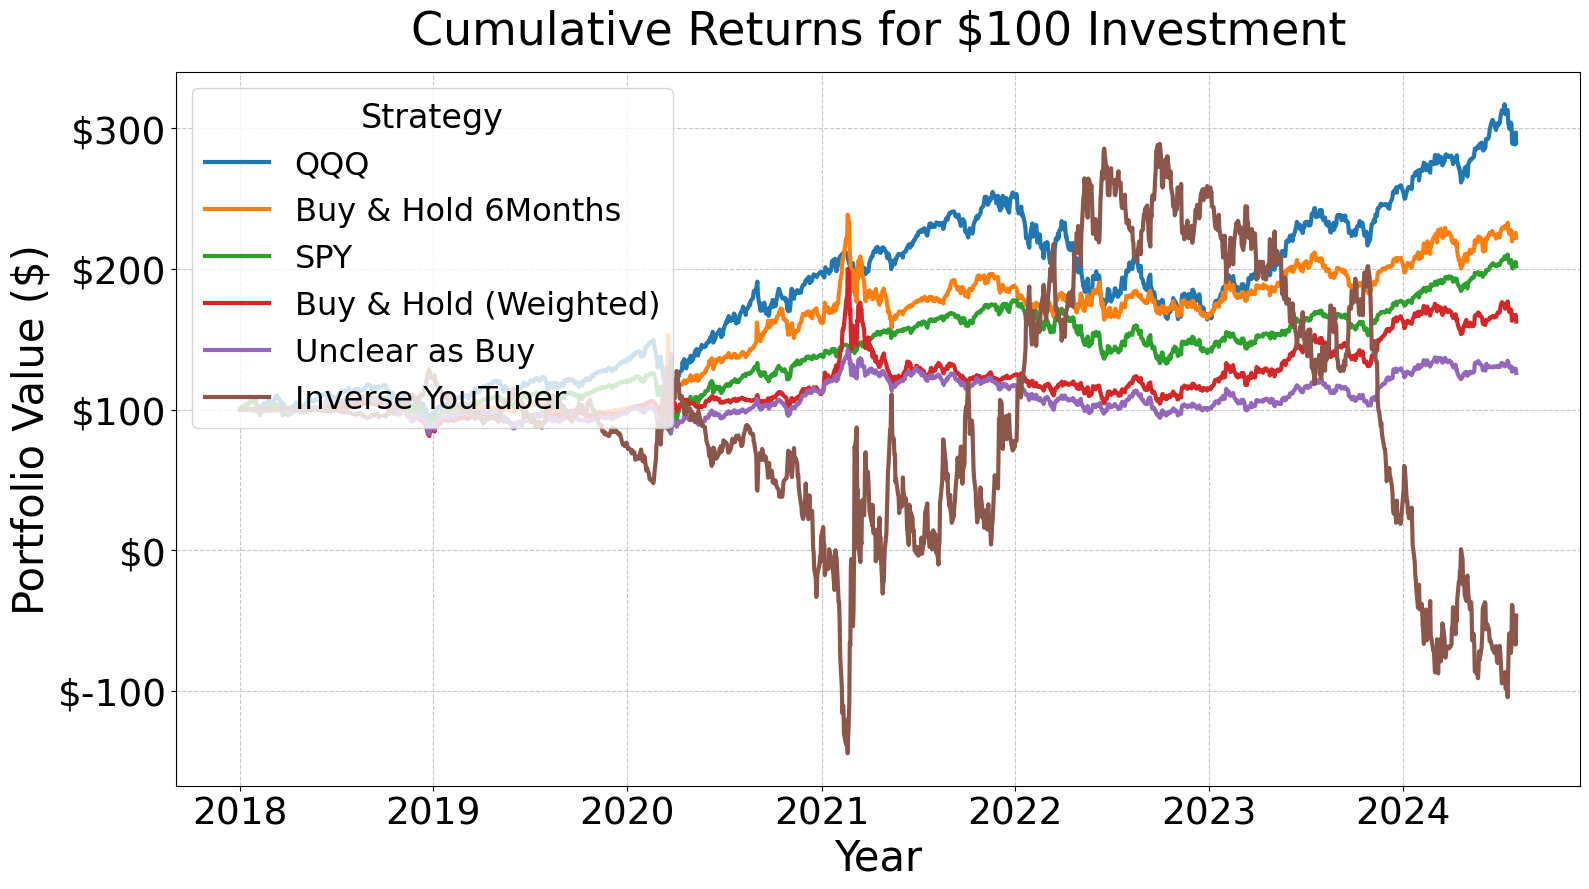

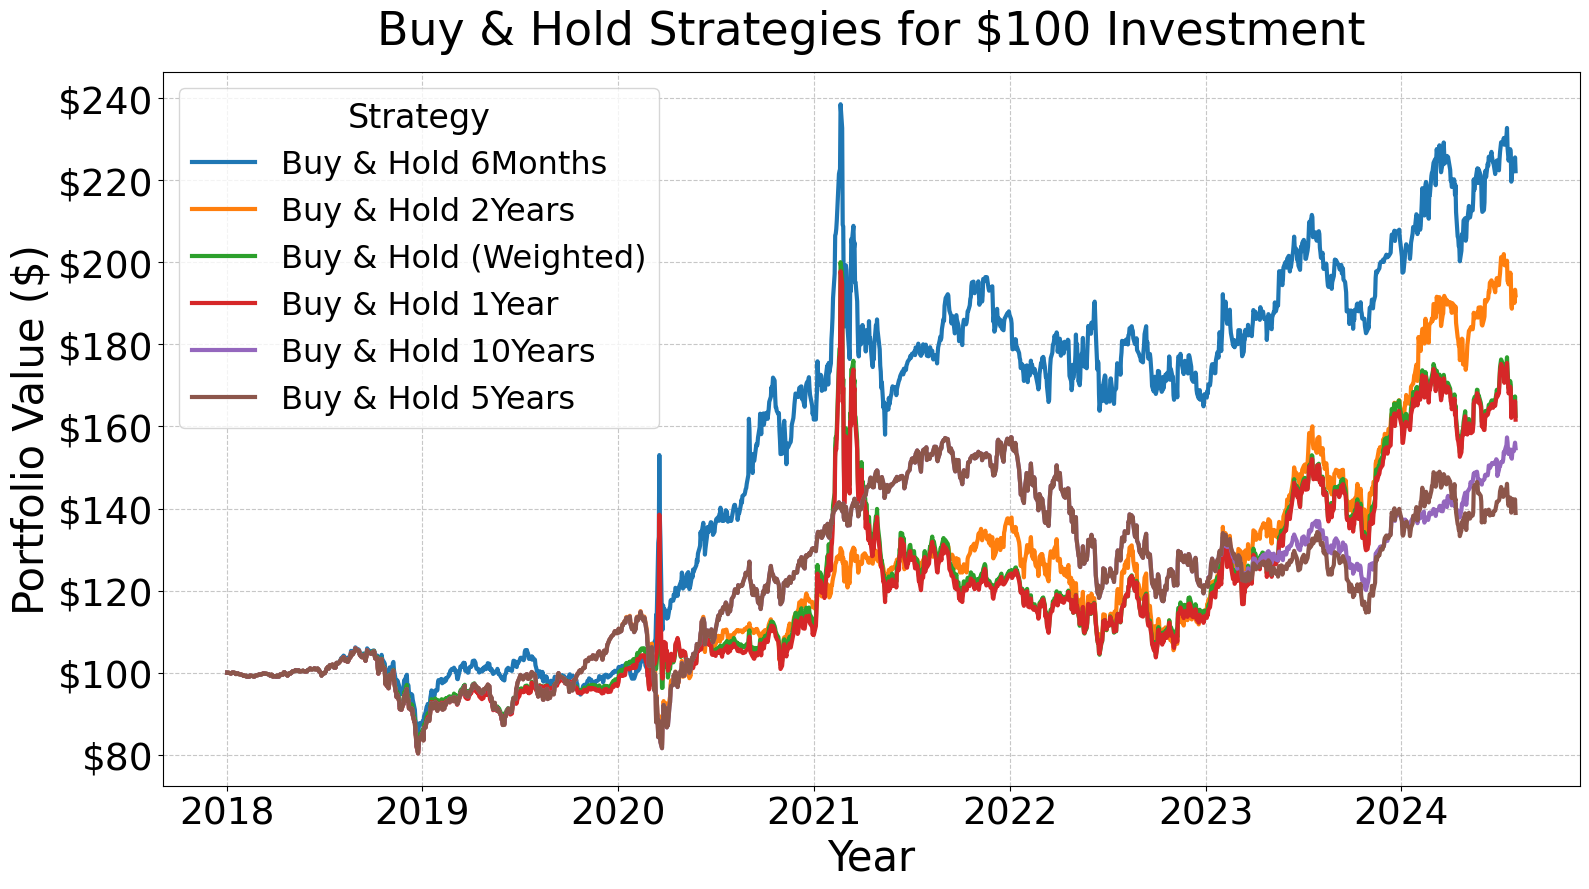

In [214]:
def clean_strategy_name(name):
    return (name.replace('HoldQQQ', 'QQQ')
                .replace('HoldSP500', 'SPY')
                .replace('BuyAndHold', 'Buy & Hold')
                .replace('YouTuberInverse', 'Inverse YouTuber')
                .replace('UnclearAsBuy', 'Unclear as Buy')
                .replace('Weighted', ' (Weighted)')
                .replace('HighConviction_6Months', 'High Conviction (6 Months)')
                .replace('MediumConviction_6Months', 'Medium Conviction (6 Months)')
                .replace('LowConviction_6Months', 'Low Conviction (6 Months)')
                .replace('_', ' '))

def set_uniform_plot_style(title, legend_title):
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_title(title, fontsize=33, pad=20)
    ax.set_xlabel('Year', fontsize=30)
    ax.set_ylabel('Portfolio Value ($)', fontsize=30)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', labelsize=27)
    ax.tick_params(axis='y', labelsize=27)
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
    return fig, ax, legend_title

def plot_cumulative_returns(analyses):
    fig, ax, legend_title = set_uniform_plot_style("Cumulative Returns for $100 Investment", "Strategy")
    group_1_strategies = [
        'BuyAndHold_6Months',
        'YouTuberInverse',
        'BuyAndHoldWeighted',
        'HoldQQQ',
        'HoldSP500',
        'UnclearAsBuy'
    ]
    strategies_to_plot = []
    for analysis in analyses:
        if analysis['name'] in group_1_strategies:
            cr = analysis['cumulative_returns'] * 100
            strategies_to_plot.append({
                'name': clean_strategy_name(analysis['name']),
                'cumulative_returns': cr,
                'final_return': cr.iloc[-1]
            })
    strategies_to_plot.sort(key=lambda x: x['final_return'], reverse=True)
    for strat in strategies_to_plot:
        ax.plot(strat['cumulative_returns'].index,
                strat['cumulative_returns'].values,
                label=strat['name'],
                linewidth=3)
    ax.legend(title=legend_title, fontsize=23, loc='upper left', title_fontsize=24)
    fig.tight_layout()
    fig.savefig("computed_graphics/Cumulative_Returns_for_100_Investment_Ordered_by_Performance.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_buy_and_hold(analyses):
    fig, ax, legend_title = set_uniform_plot_style("Buy & Hold Strategies for $100 Investment", "Strategy")
    group_2_strategies = [
        'BuyAndHold_6Months',
        'BuyAndHold_1Year',
        'BuyAndHold_2Years',
        'BuyAndHold_5Years',
        'BuyAndHold_10Years',
        'BuyAndHoldWeighted'
    ]
    strategies_to_plot = []
    for analysis in analyses:
        if analysis['name'] in group_2_strategies:
            cr = analysis['cumulative_returns'] * 100
            strategies_to_plot.append({
                'name': clean_strategy_name(analysis['name']),
                'cumulative_returns': cr,
                'final_return': cr.iloc[-1]
            })
    strategies_to_plot.sort(key=lambda x: x['final_return'], reverse=True)
    for strat in strategies_to_plot:
        ax.plot(strat['cumulative_returns'].index,
                strat['cumulative_returns'].values,
                label=strat['name'],
                linewidth=3)
    ax.legend(title=legend_title, fontsize=23, loc='upper left', title_fontsize=24)
    fig.tight_layout()
    fig.savefig("computed_graphics/Buy_Hold_Strategies_for_$100_Investment.png", dpi=300, bbox_inches='tight')
    plt.show()

with open("computed_data/Cumulative_Returns_for_100_Investment_Ordered_by_Performance.pkl", "wb") as f:
    pickle.dump(analyses, f)

plot_cumulative_returns(analyses)
plot_buy_and_hold(analyses)

In [215]:
results = []
for analysis in analyses:
    results.append({
        "Strategy Name": analysis['name'],
        "Sharpe Ratio": analysis['sharpe_ratio'],
        "Max Drawdown (%)": analysis['max_drawdown'],
        "PnL ($)": analysis['pnl'],
        "Total Return (%)": analysis['total_return'],
        "Annualized Return (%)": analysis['annualized_return'],
        "Total Closed Trades": analysis['total_trades'],
        "Winning Trades": analysis['winning_trades'],
        "Losing Trades": analysis['losing_trades'],
        "Win Rate (%)": analysis['win_rate']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Annualized Return (%)', ascending=False)
results_df

,Strategy Name,Sharpe Ratio,Max Drawdown (%),PnL ($),Total Return (%),Annualized Return (%),Total Closed Trades,Winning Trades,Losing Trades,Win Rate (%)
3,HoldQQQ,0.68,35.60,189737.10,189.74,17.55+0.00j,0,0,0,0.00
5,BuyAndHold_6Months,0.58,33.75,122188.18,122.19,12.90+0.00j,261,146,115,55.94
4,HoldSP500,0.65,34.10,102017.28,102.02,11.28+0.00j,0,0,0,0.00
7,BuyAndHold_2Years,0.53,28.34,91927.16,91.93,10.42+0.00j,87,44,43,50.57
2,BuyAndHoldWeighted,0.43,47.93,62597.96,62.60,7.67+0.00j,179,109,70,60.89
6,BuyAndHold_1Year,0.43,47.56,61656.52,61.66,7.57+0.00j,180,110,70,61.11
9,BuyAndHold_10Years,0.40,28.93,54694.82,54.69,6.86+0.00j,0,0,0,0.00
8,BuyAndHold_5Years,0.30,28.93,38920.40,38.92,5.12+0.00j,26,16,10,61.54
0,UnclearAsBuy,0.24,33.98,25982.27,25.98,3.57+0.00j,240,132,108,55.00
1,YouTuberInverse,0.22,203.51,-146404.69,-146.40,-20.97+40.90j,273,123,150,45.05


In [216]:
filtered_strategies = [
    "HoldQQQ",
    "YouTuberInverse", 
    "HoldSP500", 
    "BuyAndHold_6Months", 
    "UnclearAsBuy", 
    "BuyAndHoldWeighted"
]

filtered_results_df = results_df[results_df['Strategy Name'].isin(filtered_strategies)].copy()
filtered_results_df['PnL ($)'] = (filtered_results_df['PnL ($)'] / 100000) * 100
filtered_results_df = filtered_results_df.drop(columns=[
    'Total Closed Trades', 'Winning Trades', 'Losing Trades', 'Win Rate (%)', 'Max Drawdown (%)'
])
filtered_results_df

,Strategy Name,Sharpe Ratio,PnL ($),Total Return (%),Annualized Return (%)
3,HoldQQQ,0.68,189.74,189.74,17.55+0.00j
5,BuyAndHold_6Months,0.58,122.19,122.19,12.90+0.00j
4,HoldSP500,0.65,102.02,102.02,11.28+0.00j
2,BuyAndHoldWeighted,0.43,62.60,62.60,7.67+0.00j
0,UnclearAsBuy,0.24,25.98,25.98,3.57+0.00j
1,YouTuberInverse,0.22,-146.40,-146.40,-20.97+40.90j


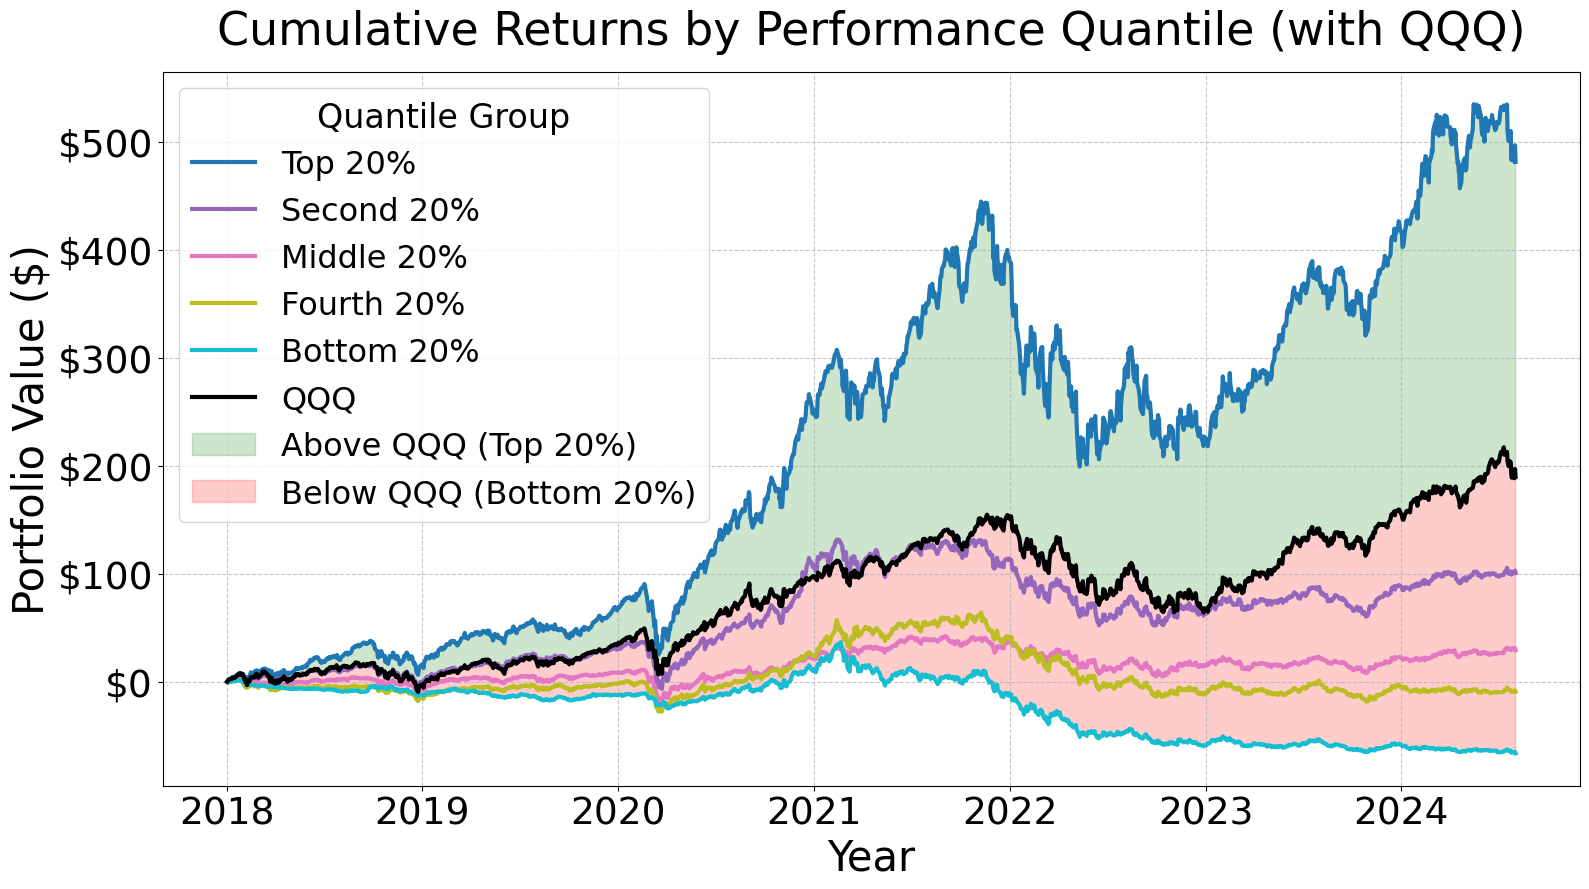

In [217]:
prices = pd.concat(
    {ticker: df['Close'] for ticker, df in historical_data.items()},
    axis=1,
    keys=historical_data.keys()
)
prices.index = all_dates
returns = prices.pct_change(fill_method=None).fillna(0)
cumulative_returns = ((1 + returns).cumprod() - 1) * 100
final_cumulative_returns = cumulative_returns.iloc[-1]

quantile_labels = [
    "Bottom 20%",
    "Fourth 20%",
    "Middle 20%",
    "Second 20%",
    "Top 20%",
]
quantile_groups = pd.qcut(final_cumulative_returns, q=5, labels=quantile_labels)

group_means = {}
final_group_returns = {}
for quantile in quantile_labels:
    group_tickers = quantile_groups[quantile_groups == quantile].index
    group_means[quantile] = cumulative_returns[group_tickers].mean(axis=1)
    final_group_returns[quantile] = group_means[quantile].iloc[-1]

hold_qqq_cumulative_returns = next(
    (item for item in analyses if item['name'] == 'HoldQQQ'), None
)['cumulative_returns']
hold_qqq_final = hold_qqq_cumulative_returns.iloc[-1] * 100 - 100
final_group_returns["HoldQQQ"] = hold_qqq_final

sorted_items = sorted(
    [
        (k, v) for k, v in final_group_returns.items()
        if k not in ["Above QQQ (Top 20%)", "Below QQQ (Bottom 20%)"]
    ],
    key=lambda x: x[1],
    reverse=True
)

fig, ax, legend_title = set_uniform_plot_style("Cumulative Returns by Performance Quantile (with QQQ)", "Quantile Group")
colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_items)))
for i, (label, _) in enumerate(sorted_items):
    if label != "HoldQQQ":
        ax.plot(
            group_means[label].index,
            group_means[label].values,
            label=label,
            linewidth=3,
            color=colors[i]
        )
ax.plot(
    hold_qqq_cumulative_returns.index,
    hold_qqq_cumulative_returns.values * 100 - 100,
    label="QQQ",
    color="black",
    linewidth=3
)

top_20 = group_means["Top 20%"].values
bottom_20 = group_means["Bottom 20%"].values
ax.fill_between(
    group_means["Top 20%"].index,
    hold_qqq_cumulative_returns.values * 100 - 100,
    top_20,
    where=(top_20 > hold_qqq_cumulative_returns.values * 100 - 100),
    color='green',
    alpha=0.2,
    label="Above QQQ (Top 20%)"
)
ax.fill_between(
    group_means["Bottom 20%"].index,
    hold_qqq_cumulative_returns.values * 100 - 100,
    bottom_20,
    where=(bottom_20 < hold_qqq_cumulative_returns.values * 100 - 100),
    color='red',
    alpha=0.2,
    label="Below QQQ (Bottom 20%)"
)
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(
    zip(handles, labels),
    key=lambda x: final_group_returns.get(x[1], -np.inf),
    reverse=True
)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
ax.legend(sorted_handles, sorted_labels, title=legend_title, fontsize=23, loc='upper left', title_fontsize=24)
fig.tight_layout()
fig.savefig("computed_graphics/Cumulative_Returns_by_Performance_Quintile_With_HoldQQQ.png", dpi=300, bbox_inches='tight')
dump_data = {
    'prices': prices,
    'returns': returns,
    'cumulative_returns': cumulative_returns,
    'final_cumulative_returns': final_cumulative_returns,
    'quantile_groups': quantile_groups,
    'group_means': group_means,
    'final_group_returns': final_group_returns,
    'hold_qqq_cumulative_returns': hold_qqq_cumulative_returns,
    'hold_qqq_final': hold_qqq_final,
    'sorted_items': sorted_items
}
with open("computed_data/Cumulative_Returns_by_Performance_Quintile_With_HoldQQQ.pkl", "wb") as f:
    pickle.dump(dump_data, f)
plt.show()

Strategy: HighConviction_6Months
  Total Return: 65.87%
  Annualized Return: 8.00%
  Sharpe Ratio: 0.5708445750047124
  Max Drawdown: 44.41%

Strategy: MediumConviction_6Months
  Total Return: 70.62%
  Annualized Return: 8.46%
  Sharpe Ratio: 0.3948392660798962
  Max Drawdown: 29.38%

Strategy: LowConviction_6Months
  Total Return: -4.81%
  Annualized Return: -0.75%
  Sharpe Ratio: 0.005016097952424576
  Max Drawdown: 51.08%



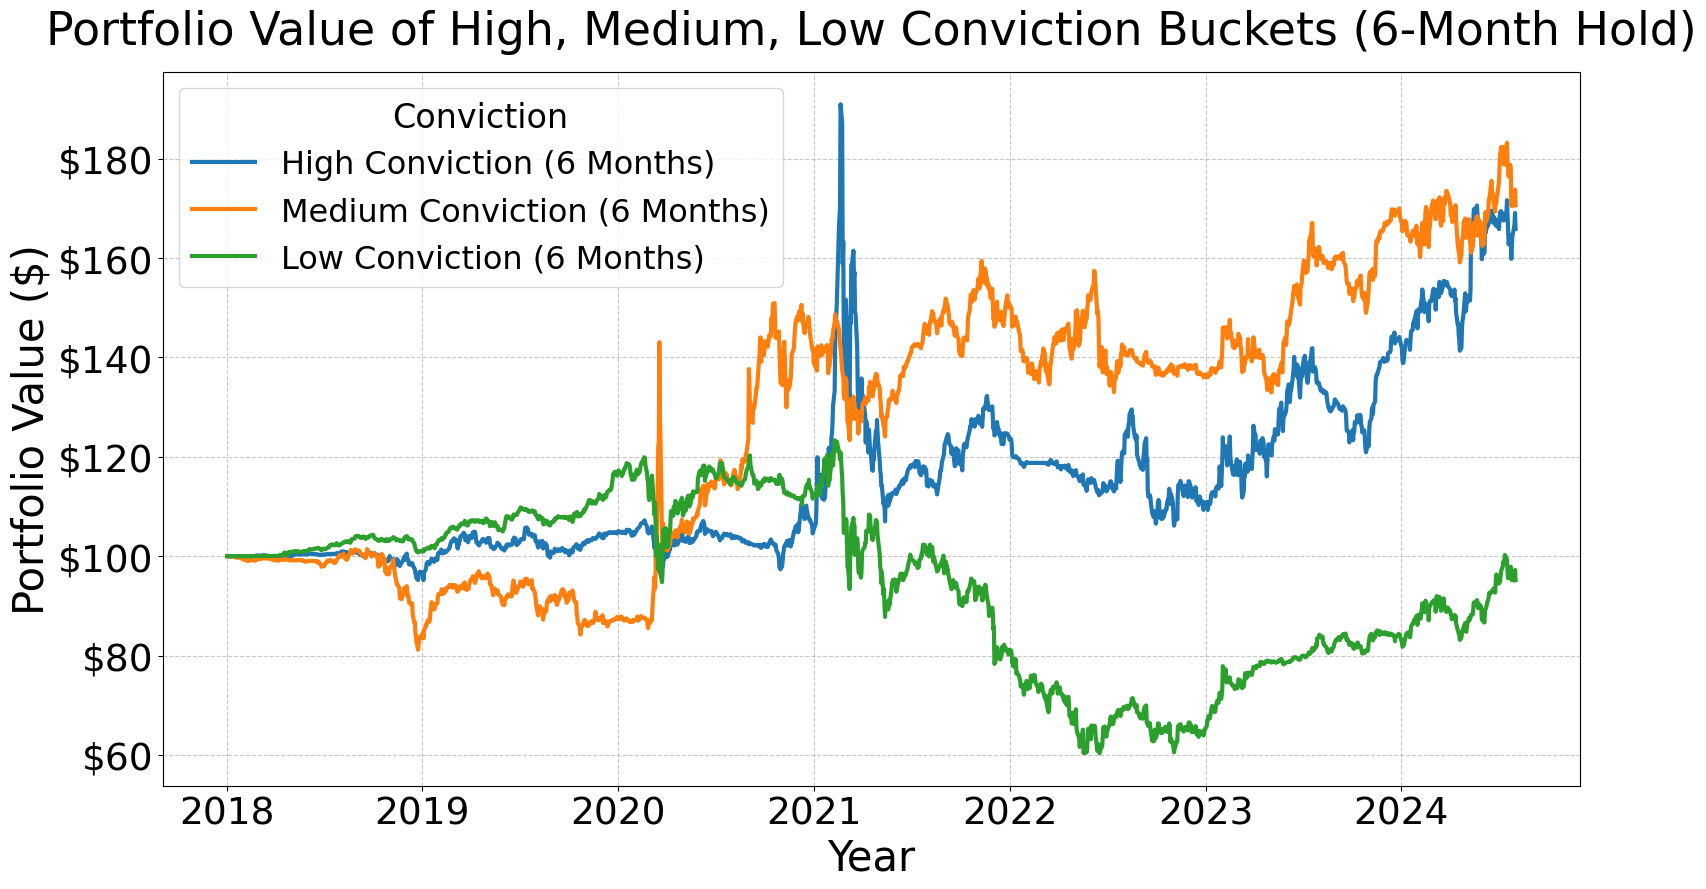

In [218]:
strategy_recs_low = defaultdict(list)
strategy_recs_medium = defaultdict(list)
strategy_recs_high = defaultdict(list)

for key, recs in strategy_recs.items():
    for rec in recs:
        score = rec['conviction_score']
        action = rec['action']
        ticker, date = key
        if action == 'Buy':
            if score == 1:
                strategy_recs_low[key].append(rec)
            elif score == 2:
                strategy_recs_medium[key].append(rec)
            elif score == 3:
                strategy_recs_high[key].append(rec)

class MyPandasData(bt.feeds.PandasData):
    params = (
        ('nullvalue', float('nan')),
        ('plot', False),
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', None)
    )

class BuyAndHoldConvictionStrategy(bt.Strategy):
    params = (
        ('hold_period', 182),
        ('strategy_recs', {}),
        ('last_date', None),
        ('max_size', 1000)
    )

    def __init__(self):
        self.buy_dates = {}
        self.strategy_recs = self.params.strategy_recs

    def next(self):
        current_date = self.datetime.date(0)
        buys = []
        for data in self.datas:
            ticker = data._name
            recommendations = self.strategy_recs.get((ticker, current_date), [])
            pos = self.getposition(data)
            for rec in recommendations:
                if rec['action'] == 'Buy' and not pos:
                    buys.append(data)
        num_trades = len(buys)
        if num_trades > 0:
            allocation = self.broker.getcash() / num_trades
            for data in buys:
                size = int(allocation / max(data.close[0], 1e-6))
                size = min(self.params.max_size, size)
                if size > 0:
                    self.buy(data=data, size=size)
                    self.buy_dates[data] = current_date
        for data in self.datas:
            pos = self.getposition(data)
            if pos.size > 0:
                buy_date = self.buy_dates.get(data)
                if buy_date:
                    holding_period = (current_date - buy_date).days
                    if holding_period >= self.params.hold_period or current_date == self.params.last_date:
                        self.sell(data=data, size=pos.size)
                        del self.buy_dates[data]

def run_backtest(strategy, name, historical_data, start_date, end_date, **strategy_params):
    cerebro = bt.Cerebro()
    strategy_params['last_date'] = last_date
    strategy_params['max_size'] = 100
    cerebro.addstrategy(strategy, **strategy_params)
    for ticker, df in historical_data.items():
        data = MyPandasData(dataname=df, name=ticker, fromdate=start_date, todate=end_date)
        cerebro.adddata(data)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.broker.setcash(100000.0)
    cerebro.broker.set_coc(True)
    results = cerebro.run()
    strat = results[0]
    sharpe_ratio = strat.analyzers.sharpe.get_analysis().get('sharperatio', None)
    drawdown = strat.analyzers.drawdown.get_analysis()
    max_drawdown = drawdown.max.drawdown
    portfolio_value = cerebro.broker.getvalue()
    initial_cash = 100000.0
    pnl = portfolio_value - initial_cash
    total_return = (portfolio_value - initial_cash) / initial_cash * 100
    returns = pd.Series(strat.analyzers.pyfolio.get_analysis()['returns'])
    returns.index = returns.index.tz_localize(None)
    cumulative_returns = (1 + returns).cumprod()
    trade_analysis = strat.analyzers.trades.get_analysis()
    total_trades = trade_analysis.total.get('closed', 0)
    winning_trades = trade_analysis.get('won', {}).get('total', 0)
    losing_trades = trade_analysis.get('lost', {}).get('total', 0)
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    all_dates = historical_data[next(iter(historical_data))].index
    start_date_ec = all_dates.min()
    end_date_ec = all_dates.max()
    total_days = (end_date_ec - start_date_ec).days
    total_years = total_days / 365.25
    annualized_return = ((portfolio_value / initial_cash) ** (1 / total_years) - 1) * 100
    analysis = {
        'name': name,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'pnl': pnl,
        'total_return': total_return,
        'annualized_return': annualized_return,
        'total_trades': total_trades,
        'winning_trades': winning_trades,
        'losing_trades': losing_trades,
        'win_rate': win_rate,
        'returns': returns,
        'cumulative_returns': cumulative_returns,
        'drawdown': drawdown,
    }
    return analysis

hold_period_days = 182

low_analysis = run_backtest(
    BuyAndHoldConvictionStrategy,
    'LowConviction_6Months',
    historical_data,
    start_date,
    end_date,
    strategy_recs=strategy_recs_low,
    hold_period=hold_period_days
)

medium_analysis = run_backtest(
    BuyAndHoldConvictionStrategy,
    'MediumConviction_6Months',
    historical_data,
    start_date,
    end_date,
    strategy_recs=strategy_recs_medium,
    hold_period=hold_period_days
)

high_analysis = run_backtest(
    BuyAndHoldConvictionStrategy,
    'HighConviction_6Months',
    historical_data,
    start_date,
    end_date,
    strategy_recs=strategy_recs_high,
    hold_period=hold_period_days
)

analyses = [high_analysis, medium_analysis, low_analysis]

for a in analyses:
    print(f"Strategy: {a['name']}")
    print(f"  Total Return: {a['total_return']:.2f}%")
    print(f"  Annualized Return: {a['annualized_return']:.2f}%")
    print(f"  Sharpe Ratio: {a['sharpe_ratio']}")
    print(f"  Max Drawdown: {a['max_drawdown']:.2f}%")
    print()

fig, ax, legend_title = set_uniform_plot_style(
    "Portfolio Value of High, Medium, Low Conviction Buckets (6-Month Hold)",
    "Conviction"
)

for a in analyses:
    cr = a['cumulative_returns']
    if cr.iloc[0] < 10:
        cr = cr * 100
    ax.plot(
        cr.index,
        cr.values,
        label=clean_strategy_name(a['name']),
        linewidth=3
    )

ax.legend(title=legend_title, fontsize=23, loc='upper left', title_fontsize=24)
fig.tight_layout()
fig.savefig("computed_graphics/Cumulative_Returns_High_Medium_Low_Conviction_Buckets_6Month_Hold.png", dpi=300, bbox_inches='tight')
dump_data = {
    "analyses": analyses,
    "normalized_returns": {
        a["name"]: [100 * r / a["cumulative_returns"].iloc[0] for r in a["cumulative_returns"]]
        for a in analyses
    }
}
with open("computed_data/Cumulative_Returns_High_Medium_Low_Conviction_Buckets_6Month_Hold.pkl", "wb") as f:
    pickle.dump(dump_data, f)
plt.show()